### The effect of randomisation

The purpose of this notebook is to highlight the different way in which the two estimation methodologies (NPSMLE and SMM) approach the role of the pseudo-random numbers used in the MC methods. This shows the radical difference in philosophy between these approaches, and provides insights into what more recent surrogate methodologies try to achieve.

**Note:** The code itself is rather short, but beware, because of the nested loops required to generate the response surfaces, it takes a long time to re-compute (~45 minutes).

We're essentially re-using the setting of the simple AR(2) example, so the initial imports and functions are the same.

In [1]:
import time
import numpy as np
from workshopFunctions import AR, smm, npsmle, autocorr, formatTableText

from scipy.stats import norm, skew
from numpy.random import default_rng
from matplotlib import pyplot as plt
# --------------------------------------------------------------------------
# Declare any extra functions

def genMoments(data):
    """
    Generate the moments

    Parameters
    ----------
    data : numpy 1D array of floats
        Input data..

    Returns
    -------
    moments : numpy 1D array of floats
        Vector containing the moments of interest

    """
    data = data.flatten() # in case the data isn't already flat

    # Append moments below. This will need to change for each problem
    acf = autocorr(data)
    moments = np.array(np.mean(data))
    moments = np.append(moments,np.var(data))
    moments = np.append(moments,skew(data))
    moments = np.append(moments,acf[1])
    moments = np.append(moments,acf[2])
    
    return moments

We're also going to reuse the same 'empirical' dataset as for the simple AR(2) notebook example.

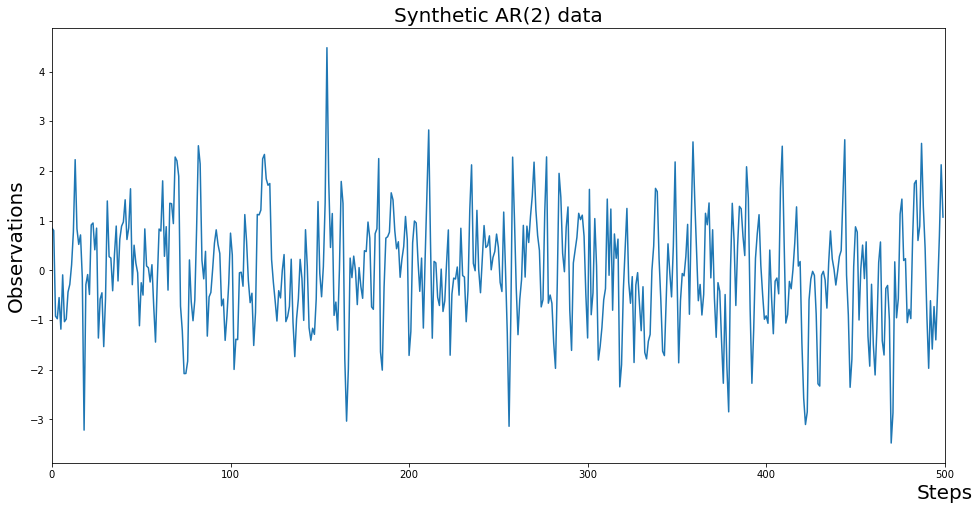

In [2]:
betaVec = np.asarray([0.7,-0.2])    # Pick some AR parameters
T = 500                             # pick simulation length
paramNames = ['Beta_1', 'Beta_2']

ARsim = AR(seed = 3)
ARsimData = ARsim.simulate(T+2,betaVec)
y = ARsimData[2:T+2]

# Plot the data
fig = plt.figure(figsize=(16,8))
fig.set_facecolor('white')
ax = plt.axes()
ax.plot(np.arange(T), y)
ax.set_xlim(0,T)
ax.set_xlabel(r'Steps', fontdict = {'fontsize': 20},position=(1, 0))
ax.set_ylabel(r'Observations', fontdict = {'fontsize': 20},position=(0, 0.5))
ax.set_title('Synthetic AR(2) data', fontdict = {'fontsize': 20});

Now, let's generate a grid centered on the true values of our parameters, $\beta_1 = 0.7$ and $\beta_2 = -0.2$. We extend the grid by $0.2$ in either direction, so that the surfaces we obtain as a result will provide a visualisation of the optimisation surfaces of the simple AR notebook in the neighborhood of the true parameters.

For both NPSMLE and SMM we will look at two cases (so 4 cases in total):
- One where the random numbers are fixed across gridpoint evaluations (fixed vector of shocks for NPSMLE, fixed initialisation seed for the SMM simulations)
- One where they are different (either by supplying different random numbers to NPSMLE, or by initialising the AR simulation used by SMM with a different seed)

In [3]:
# Generate optimisation surfaces in the neighbourhood of the optimum
gridRes = 25
N = 500
paramRange = np.linspace(-0.2,0.2,gridRes)
beta1Grid, beta2Grid = np.meshgrid(
                            betaVec[0] + paramRange,
                            betaVec[1] + paramRange)
surfaces = np.zeros([gridRes,gridRes,4])

epsRng = default_rng(seed = 400)
epsilon = norm.ppf(epsRng.random((N,1)))

# Generate an instance of each of the metrics (NPSMLE and SMM)
ARnpsmle = npsmle(y, paramNames)
ARsmm = smm(y, genMoments, paramNames, bootstrap = True) # 'automatic' SMM, with bootstrap

# Iterate over the grid. This is the costly bit...
print('Iterating over gridpoints - nested loops, I know...')
for i in range(gridRes):
    npsmleTime = 0
    smmTime = 0
    for j in range(gridRes):
        paramVec = np.asarray([beta1Grid[i,j],beta2Grid[i,j]])
        
        t_start = time.time()
        surfaces[i,j,0] = -sum(ARnpsmle.logLike(ARsim.step,
                               2,
                               paramVec,
                               epsilon)/T)
        
        epsilon2 = norm.ppf(epsRng.random((N,1)))
        surfaces[i,j,1] = -sum(ARnpsmle.logLike(ARsim.step,
                               2,
                               paramVec,
                               epsilon2)/T)
        npsmleTime += time.time() - t_start
        
        t_start = time.time()
        surfaces[i,j,2] = ARsmm.dist(ARsim.simulate,paramVec, N=N)
        
        ARsimFuzzy = AR(seed = gridRes*i + j)
        surfaces[i,j,3] = ARsmm.dist(ARsimFuzzy.simulate,paramVec, N=N)
        smmTime += time.time() - t_start
        
    print(' Row {:2d} - NPSMLE: {:8.4f} secs. SMM: {:8.4f} secs.'.format(i+1,
                                                                         npsmleTime,
                                                                         smmTime))

Iterating over gridpoints - nested loops, I know...
 Row  1 - NPSMLE:  12.9282 secs. SMM:  81.1320 secs.
 Row  2 - NPSMLE:  11.9056 secs. SMM:  71.2580 secs.
 Row  3 - NPSMLE:  11.9590 secs. SMM:  71.1624 secs.
 Row  4 - NPSMLE:  11.8729 secs. SMM:  70.8189 secs.
 Row  5 - NPSMLE:  11.8241 secs. SMM:  71.9169 secs.
 Row  6 - NPSMLE:  11.8108 secs. SMM:  70.3327 secs.
 Row  7 - NPSMLE:  11.6776 secs. SMM:  69.8696 secs.
 Row  8 - NPSMLE:  11.8830 secs. SMM:  71.9885 secs.
 Row  9 - NPSMLE:  12.5541 secs. SMM:  77.4515 secs.
 Row 10 - NPSMLE:  11.6878 secs. SMM:  69.9861 secs.
 Row 11 - NPSMLE:  11.6885 secs. SMM:  69.8793 secs.
 Row 12 - NPSMLE:  11.6572 secs. SMM:  68.8198 secs.
 Row 13 - NPSMLE:  11.6760 secs. SMM:  68.9397 secs.
 Row 14 - NPSMLE:  11.7194 secs. SMM:  70.4523 secs.
 Row 15 - NPSMLE:  13.2738 secs. SMM:  79.4126 secs.
 Row 16 - NPSMLE:  12.1208 secs. SMM:  73.7616 secs.
 Row 17 - NPSMLE:  12.1624 secs. SMM:  73.6937 secs.
 Row 18 - NPSMLE:  12.4050 secs. SMM:  77.1428 

Finally, we are done...

Let's plot the four surfaces for comparison. Note, that we also quickly calculate the value of the objective functions at the true values, to better identify the location of the optimum point on the surface.

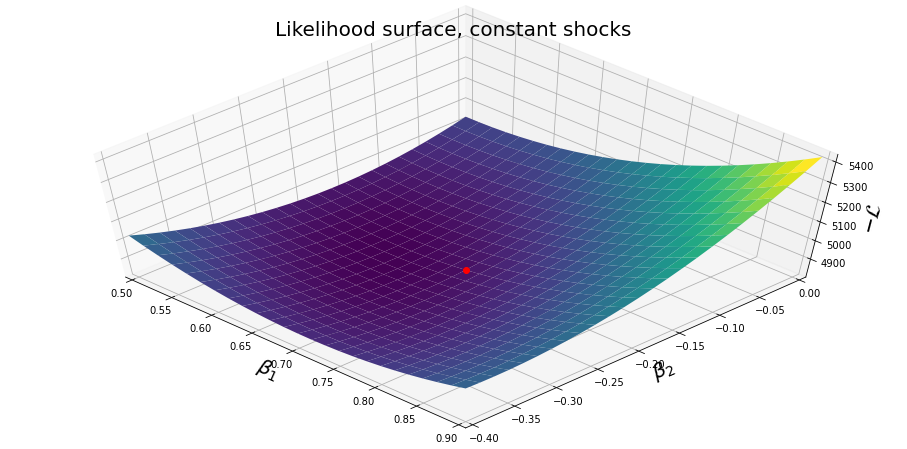

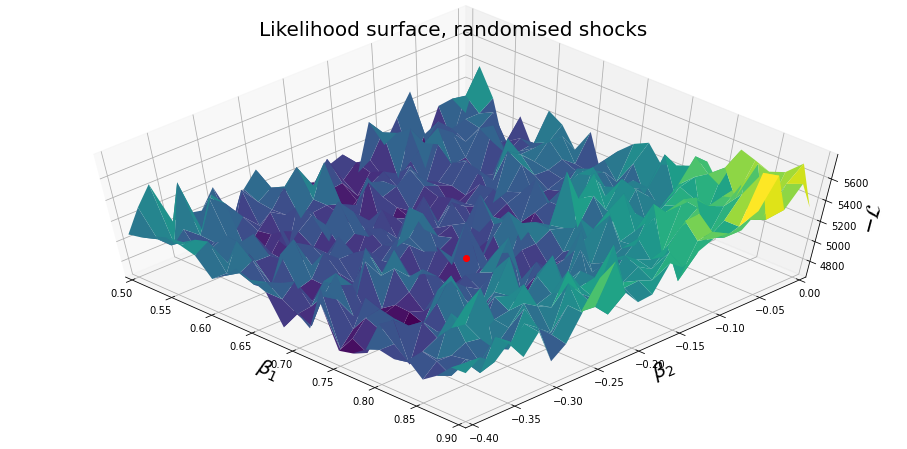

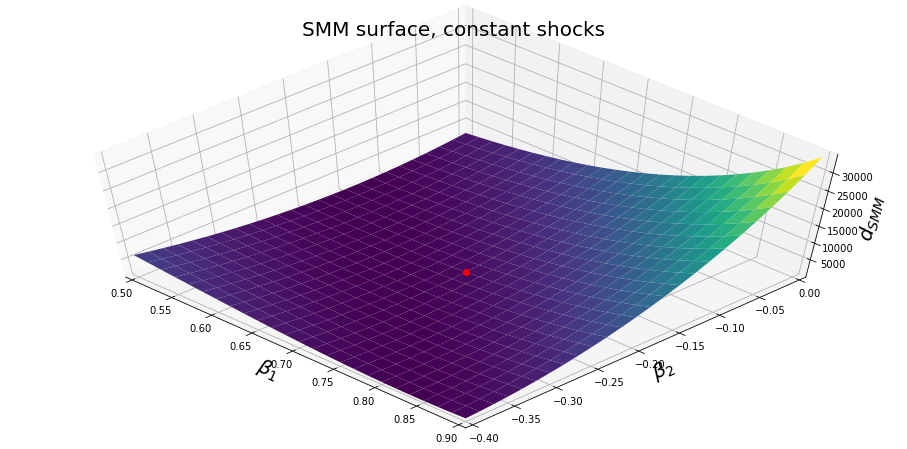

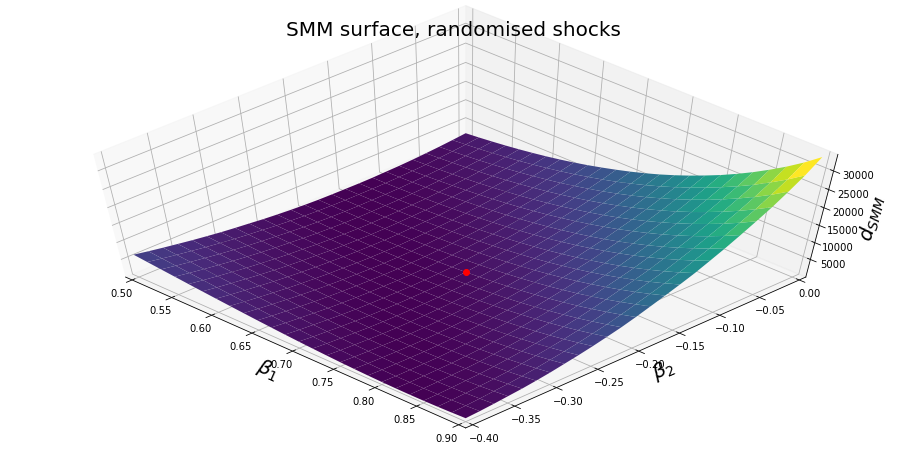

In [4]:
# Establish the objective function values  at the optimal point
npsmleTrue = -sum(ARnpsmle.logLike(ARsim.step,
                               2,
                               betaVec,
                               epsilon)/T)

smmTrue = ARsmm.dist(ARsim.simulate,betaVec, N=N)

# Plot the surfaces
elev = 60
azim = -45

labels = [r'$-\mathcal{L}$', r'$d_{SMM}$']
truths = [npsmleTrue,smmTrue]
titles = ['Likelihood','SMM']
shocks = ['constant','randomised']

for i in range (4):
    j = int(np.floor(i/2))
    k = i % 2
    fig = plt.figure(figsize=(16,8))
    fig.set_facecolor('white')
    ax = plt.axes(projection='3d')
    ax.plot_surface(beta1Grid, beta2Grid, surfaces[:,:,i], cmap='viridis')
    ax.plot3D([betaVec[0]], [betaVec[1]], [truths[j]], 
              marker = 'o', color = 'r', zorder = 5)
    ax.view_init(elev, azim)        
    ax.set_xlim(betaVec[0]-0.2,betaVec[0]+0.2)
    ax.set_ylim(betaVec[1]-0.2,betaVec[1]+0.2)
    ax.set_xlabel(r'$\beta_1$', fontdict = {'fontsize': 20},position=(1, 0))
    ax.set_ylabel(r'$\beta_2$', fontdict = {'fontsize': 20},position=(0, 1))
    ax.set_zlabel(labels[j], fontdict = {'fontsize': 20}, position=(0, 1))
    ax.set_title('{:s} surface, {:s} shocks'.format(titles[j],shocks[k]),
                 fontdict = {'fontsize': 20});

What we see is that the performance of the NPMLE depends crucially on the random numbers staying fixed as we move around on the response surface: if new draws are supplied, then the response surface become swamped by Monte Carlo noise, and it becomes impossible to optimise.

SMM on the other hand doesn't really care. Unless you look really close, you probably can't tell the difference. This is because it is an ensemble method: we are calculating moments of simulation data averaged over many MC replications, so variations in the simulation data that are due to different random draws are being washed out anyway. The ensemble averaging is more robust, but also more time-consuming as a result.

Given that SMM is the method that really cost most of the compute time in the grid search, doesn't this little exercise all comes across as a bit of a waste of time? Yes, it does. But it gives us an important insight into the features we'd like from a simulation-based methodology: something fast and elegant like the one-step-ahead likelihood used in NPSMLE, but robust to noise like SMM.
